# Prediksi Risiko Stunting pada Balita Menggunakan Model Machine Learning
- **Nama:** Lathif Nurma Huda   
- **Email:** mc604d5y0872@student.devacademy.id
- **ID Dicoding:** MC604D5Y0872

Proyek ini bertujuan untuk membangun model prediktif guna mengidentifikasi risiko stunting pada balita berdasarkan data demografi dan kesehatan. Dataset diambil dari [Kaggle - Stunting Balita Detection ](https://www.kaggle.com/datasets/rendiputra/stunting-balita-detection-121k-rows).


## Import Library yang dibutuhkan


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')


In [2]:
!pip install -q kaggle

## Data Loading

In [33]:
from google.colab import files
files.upload()

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d rendiputra/stunting-balita-detection-121k-rows

Dataset URL: https://www.kaggle.com/datasets/rendiputra/stunting-balita-detection-121k-rows
License(s): MIT
  0% 0.00/340k [00:00<?, ?B/s]
100% 340k/340k [00:00<00:00, 678MB/s]


In [6]:
import zipfile
import os

zip_path = "stunting-balita-detection-121k-rows.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("stunting_dataset")

# Lihat isi folder
os.listdir("stunting_dataset")

['data_balita.csv']

In [7]:
df = pd.read_csv("stunting_dataset/data_balita.csv")

In [8]:
# Ambil sampel 5000 baris data secara acak
df_sample = df.sample(n=5000, random_state=42)

# Tampilkan 5 baris pertama sampel
df_sample.head()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
17917,8,perempuan,70.1,normal
6976,3,laki-laki,65.4,normal
37592,19,laki-laki,72.9,severely stunted
89657,45,laki-laki,89.1,severely stunted
117023,59,laki-laki,94.0,severely stunted


In [9]:
from sklearn.model_selection import train_test_split

# Stratified sampling (ambil 5000 baris dengan proporsi target yang sama)
df_sample, _ = train_test_split(df, train_size=5000, stratify=df['Status Gizi'], random_state=42)

# Cek distribusi label setelah sampling
df_sample['Status Gizi'].value_counts(normalize=True)


,proportion
Status Gizi,
normal,0.5600
severely stunted,0.1642
tinggi,0.1616
stunted,0.1142


In [10]:
df_sample.to_csv("stunting_sampled.csv", index=False)

In [11]:
df = pd.read_csv('stunting_sampled.csv')
df_sample = df.sample(n=5000, random_state=42)

## Exploratory Data Analysis

In [12]:
df

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,6,perempuan,70.5,normal
1,27,perempuan,93.1,normal
2,60,laki-laki,122.2,normal
3,41,laki-laki,87.4,severely stunted
4,30,laki-laki,85.0,stunted
...,...,...,...,...
4995,15,laki-laki,84.0,normal
4996,56,laki-laki,124.9,tinggi
4997,42,perempuan,111.8,tinggi
4998,49,perempuan,111.6,normal


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Umur (bulan)       5000 non-null   int64  
 1   Jenis Kelamin      5000 non-null   object 
 2   Tinggi Badan (cm)  5000 non-null   float64
 3   Status Gizi        5000 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 156.4+ KB


In [14]:
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
df.rename(columns={
    'umur_(bulan)': 'umur',
    'tinggi_badan_(cm)': 'tinggi_badan',
    'status_gizi': 'stunting'  # jika ini adalah label target
}, inplace=True)

In [15]:
df.describe()

,umur,tinggi_badan
count,5000.000000,5000.000000
mean,30.082400,88.534670
std,17.682628,17.431973
min,0.000000,40.154283
25%,15.000000,76.800000
50%,30.000000,90.100000
75%,45.000000,101.200000
max,60.000000,127.000000


In [16]:
df.duplicated().sum()

np.int64(312)

In [17]:
# Hapus semua baris duplikat
df = df.drop_duplicates()

# Cek ulang jumlah duplikat setelah penghapusan
print("Jumlah duplikat setelah dibersihkan:", df.duplicated().sum())


Jumlah duplikat setelah dibersihkan: 0


In [18]:
df.isnull().sum()

,0
umur,0
jenis_kelamin,0
tinggi_badan,0
stunting,0


## Menangani Outlier

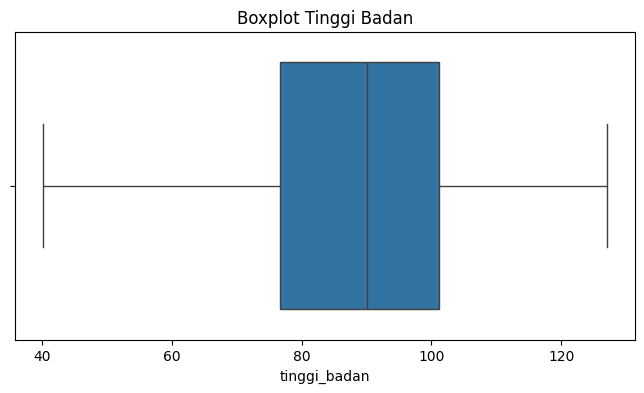

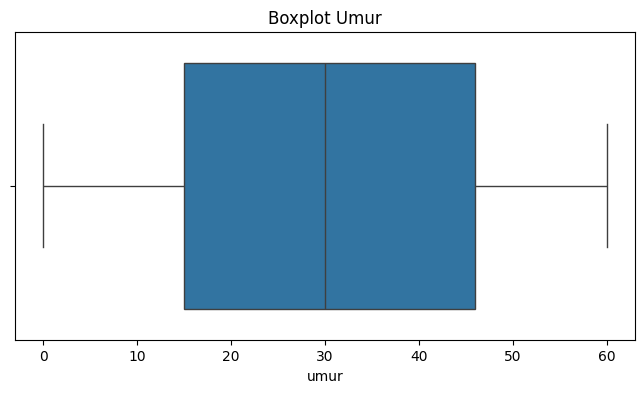

In [19]:
# Boxplot untuk kolom 'tinggi_badan'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['tinggi_badan'])
plt.title('Boxplot Tinggi Badan')
plt.show()

# Boxplot untuk kolom 'umur'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['umur'])
plt.title('Boxplot Umur')
plt.show()

In [20]:
# Fungsi untuk menghapus outlier berdasarkan IQR
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter data
    return dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]

# Hapus outlier dari kolom 'tinggi_badan' dan 'umur'
df = remove_outliers_iqr(df, 'tinggi_badan')
df = remove_outliers_iqr(df, 'umur')

# Cek jumlah data setelah pembersihan
print("Jumlah data setelah menghapus outlier:", len(df))

Jumlah data setelah menghapus outlier: 4688


## Univariate Analysis

### Kolom Numerik

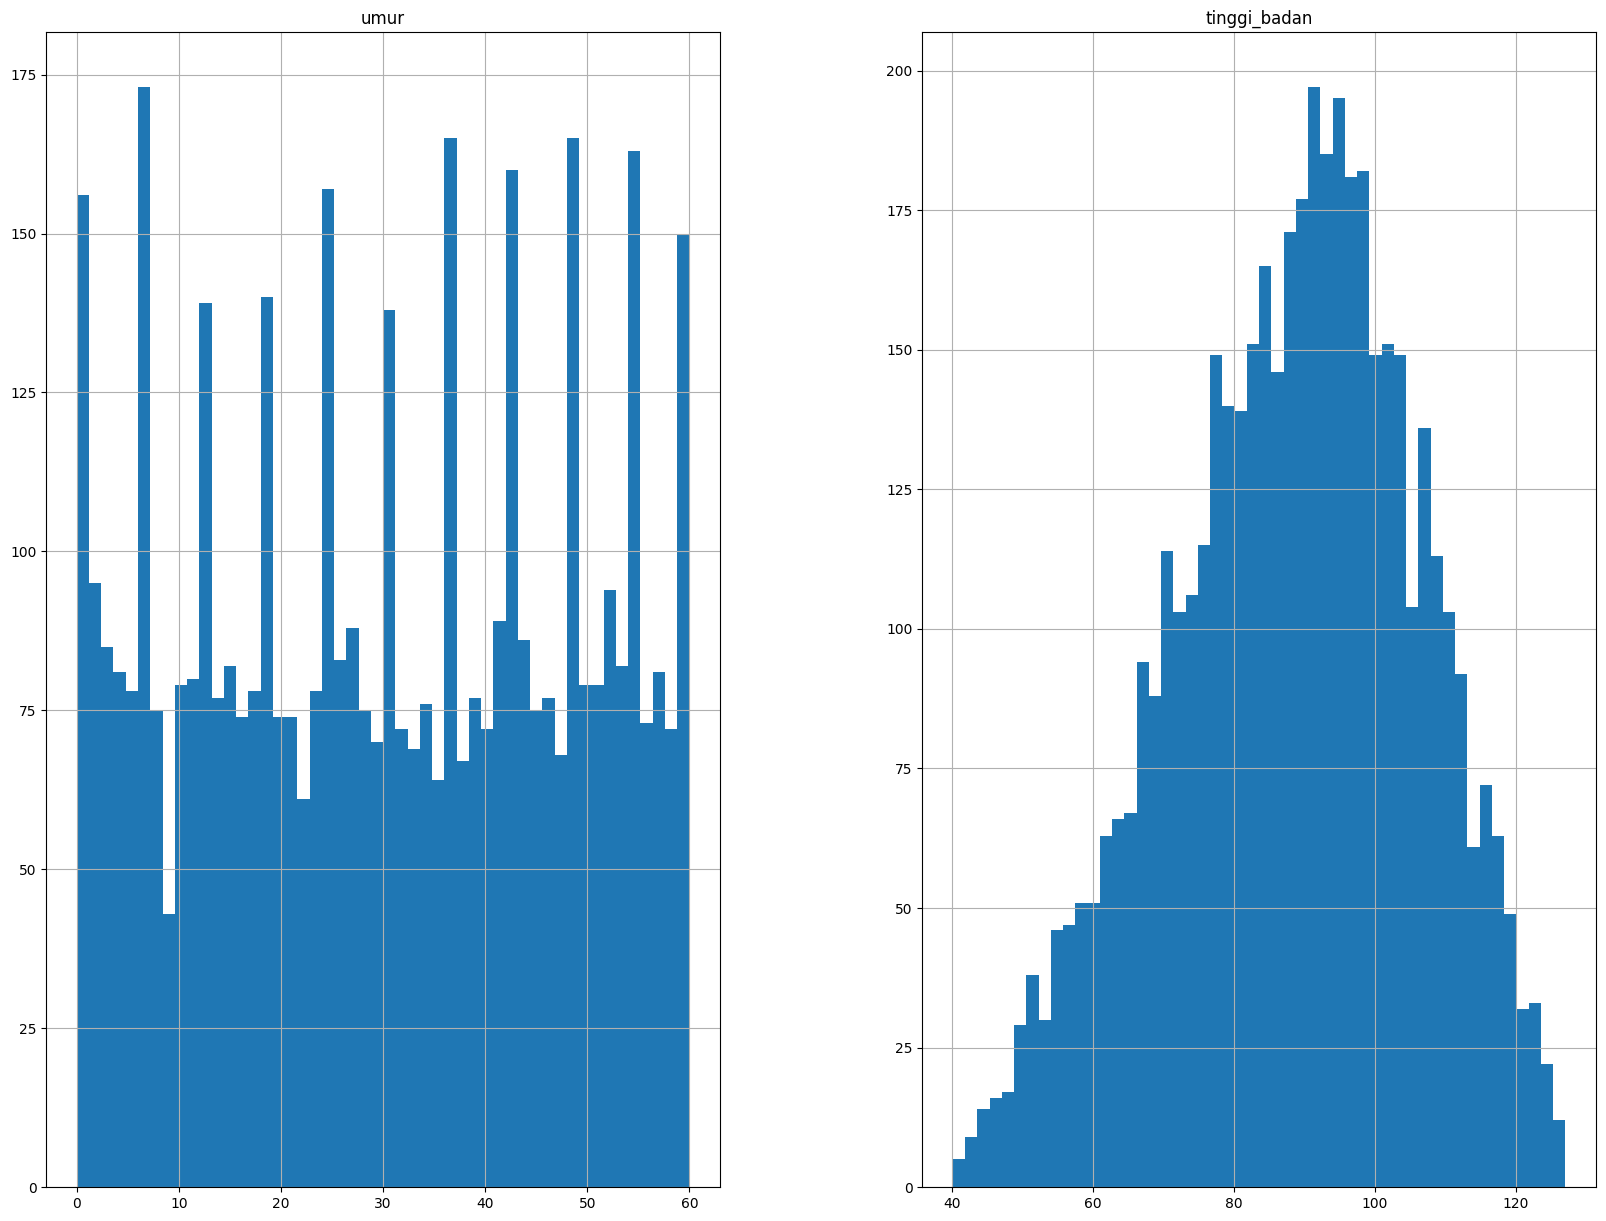

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

### Kolom kategorikal

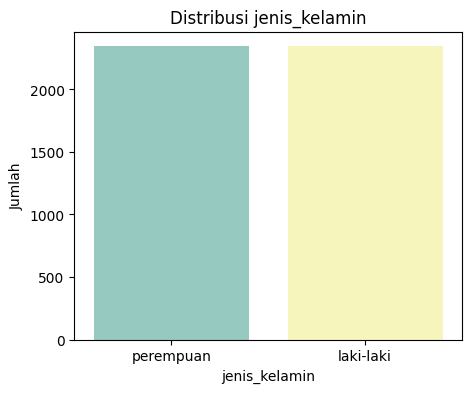

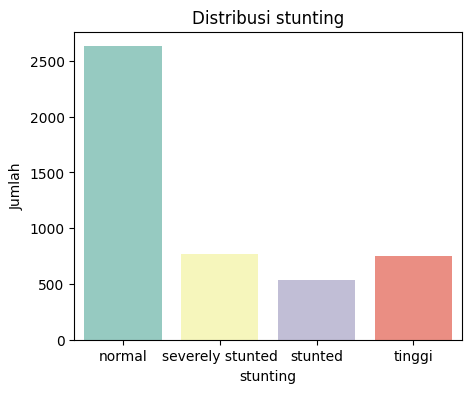

In [ ]:
categorical_cols = ['jenis_kelamin', 'stunting']

for col in categorical_cols:
    plt.figure(figsize=(5,4))
    sns.countplot(x=col, data=df, palette='Set3')
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Jumlah')
    plt.show()


### Multivariate Analysis

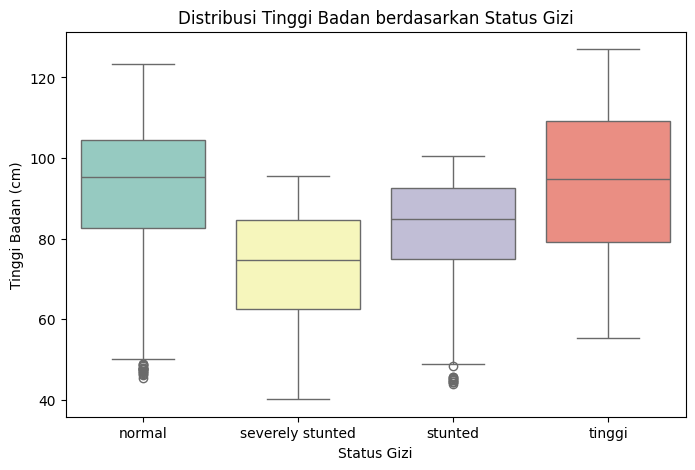

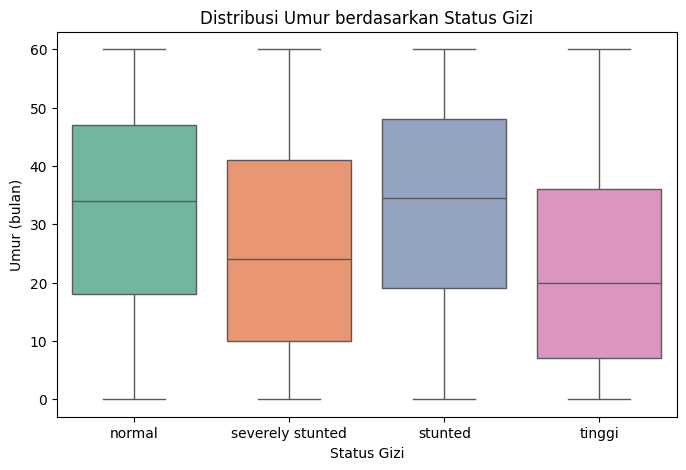

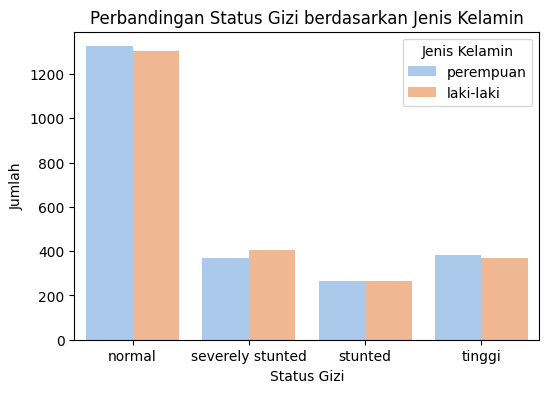

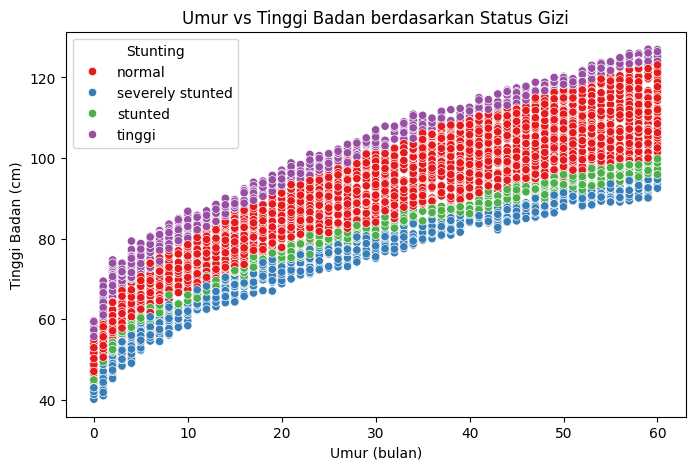

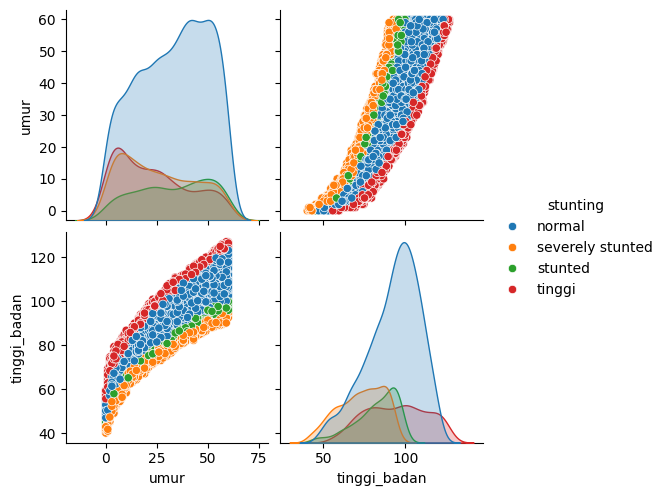

In [ ]:
#Distribusi tinggi badan terhadap status gizi
plt.figure(figsize=(8, 5))
sns.boxplot(x='stunting', y='tinggi_badan', data=df, palette='Set3')
plt.title('Distribusi Tinggi Badan berdasarkan Status Gizi')
plt.xlabel('Status Gizi')
plt.ylabel('Tinggi Badan (cm)')
plt.show()

#Distribusi umur terhadap status gizi
plt.figure(figsize=(8, 5))
sns.boxplot(x='stunting', y='umur', data=df, palette='Set2')
plt.title('Distribusi Umur berdasarkan Status Gizi')
plt.xlabel('Status Gizi')
plt.ylabel('Umur (bulan)')
plt.show()

#Perbandingan Status Gizi dan Jenis Kelamin
plt.figure(figsize=(6, 4))
sns.countplot(x='stunting', hue='jenis_kelamin', data=df, palette='pastel')
plt.title('Perbandingan Status Gizi berdasarkan Jenis Kelamin')
plt.xlabel('Status Gizi')
plt.ylabel('Jumlah')
plt.legend(title='Jenis Kelamin')
plt.show()

#Scatterplot Umur vs Tinggi Badan, dipisah berdasarkan Status Gizi
plt.figure(figsize=(8, 5))
sns.scatterplot(x='umur', y='tinggi_badan', hue='stunting', data=df, palette='Set1')
plt.title('Umur vs Tinggi Badan berdasarkan Status Gizi')
plt.xlabel('Umur (bulan)')
plt.ylabel('Tinggi Badan (cm)')
plt.legend(title='Stunting')
plt.show()

sns.pairplot(df, diag_kind='kde', hue='stunting')


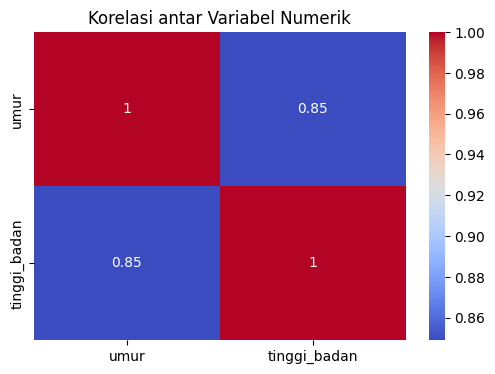

In [ ]:
# Korelasi dan heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[['umur', 'tinggi_badan']].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi antar Variabel Numerik')
plt.show()


## Data Preparation

### Encoding kolom kategorikal

In [21]:
from sklearn.preprocessing import LabelEncoder

le_jenis_kelamin = LabelEncoder()
le_stunting = LabelEncoder()

df['jenis_kelamin'] = le_jenis_kelamin.fit_transform(df['jenis_kelamin'])  # L, P -> 0, 1
df['stunting'] = le_stunting.fit_transform(df['stunting'])  # Normal, Stunting -> 0, 1 (misal)


In [22]:
print(df['jenis_kelamin'].unique())
print(df['stunting'].unique())

[1 0]
[0 1 2 3]


### Split Train Test

In [23]:
X = df.drop('stunting', axis=1)  # Fitur
y = df['stunting']               # Target

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
print(f"Total jumlah sampel dalam dataset keseluruhan: {len(X)}")
print(f"Total jumlah sampel dalam dataset pelatihan (train): {len(X_train)}")
print(f"Total jumlah sampel dalam dataset pengujian (test): {len(X_test)}")

Total jumlah sampel dalam dataset keseluruhan: 4688
Total jumlah sampel dalam dataset pelatihan (train): 3750
Total jumlah sampel dalam dataset pengujian (test): 938


### Normalisasi

In [26]:
from sklearn.preprocessing import StandardScaler

# Daftar kolom numerik
numerical_features = ['umur', 'tinggi_badan']

# Inisialisasi dan fit scaler pada data latih
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])

# Transformasi data latih dan data uji
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Tampilkan 5 baris pertama data yang telah dinormalisasi
X_train[numerical_features].head()


,umur,tinggi_badan
625,0.727632,0.420570
2506,-1.576282,-2.097865
1199,0.109509,-0.592714
4087,1.064790,0.283948
2051,-1.520088,-1.036737


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Inisialisasi model
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Melatih model
knn.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Prediksi
knn_pred_train = knn.predict(X_train)
knn_pred_test  = knn.predict(X_test)

rf_pred_train = rf.predict(X_train)
rf_pred_test  = rf.predict(X_test)

gb_pred_train = gb.predict(X_train)
gb_pred_test  = gb.predict(X_test)

# Menyimpan skor akurasi
models = pd.DataFrame(index=['train_accuracy', 'test_accuracy'],
                      columns=['KNN', 'RandomForest', 'Boosting'])

models.loc['train_accuracy', 'KNN'] = accuracy_score(y_train, knn_pred_train)
models.loc['test_accuracy', 'KNN']  = accuracy_score(y_test, knn_pred_test)

models.loc['train_accuracy', 'RandomForest'] = accuracy_score(y_train, rf_pred_train)
models.loc['test_accuracy', 'RandomForest']  = accuracy_score(y_test, rf_pred_test)

models.loc['train_accuracy', 'Boosting'] = accuracy_score(y_train, gb_pred_train)
models.loc['test_accuracy', 'Boosting']  = accuracy_score(y_test, gb_pred_test)

## Evaluasi Model

In [30]:
# Tampilkan hasil
print("Hasil akurasi masing-masing model:\n")
print(models)

Hasil akurasi masing-masing model:

                     KNN RandomForest  Boosting
train_accuracy    0.9736          1.0  0.961867
test_accuracy   0.954158     0.958422  0.926439


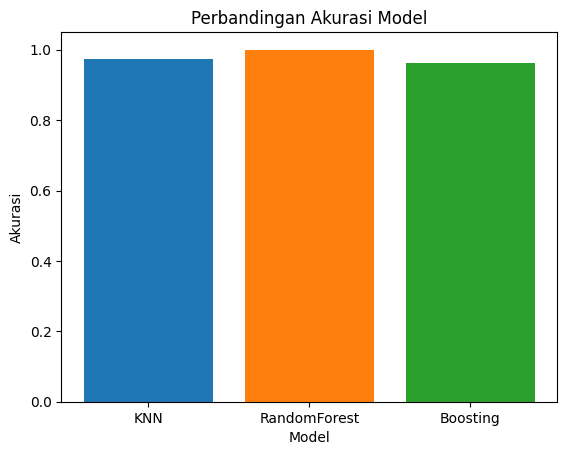

In [32]:
plt.bar('KNN', models['KNN'])
plt.bar('RandomForest', models['RandomForest'])
plt.bar('Boosting', models['Boosting'])
plt.title("Perbandingan Akurasi Model");
plt.xlabel('Model');
plt.ylabel('Akurasi');
plt.show()